In [23]:
initial_condition_version = 'unit vectors'        # 'trajectory', 'unit vectors'

trained_obs_model_version = 'regularized gaussian obs model'  # 'gaussian obs model', 'regularized obs model'

Correlate the empirical covariance matrix of residuals with the separately trained $\Gamma$ matrix from the Gaussian obs model

Gamma: Mean Correlation MRT 2: 0.988 ± 0.003
Gamma: Mean Norm Ratio MRT 2: 0.620 ± 0.032
B: Mean Correlation MRT 2: 0.944 ± 0.012
B: Mean Norm Ratio MRT 2: 0.976 ± 0.008
Network: Mean Correlation MRT 2: 0.702 ± 0.046
Network: Mean Norm Ratio MRT 2: 1.881 ± 0.271
Gamma: Mean Correlation MRT 3: 0.988 ± 0.003
Gamma: Mean Norm Ratio MRT 3: 0.606 ± 0.028
B: Mean Correlation MRT 3: 0.940 ± 0.012
B: Mean Norm Ratio MRT 3: 0.973 ± 0.009
Network: Mean Correlation MRT 3: 0.687 ± 0.045
Network: Mean Norm Ratio MRT 3: 1.764 ± 0.230


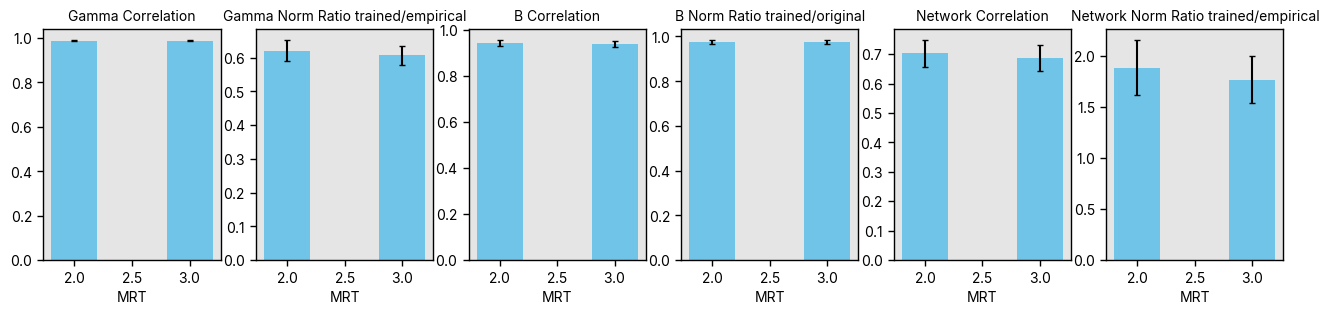

Errors loading model: 1


In [24]:
import sys
sys.path.append('..')
import numpy as np
import torch as tc
import pandas as pd
import matplotlib.pyplot as plt
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle, colors
import plotting_utils
from bptt.plrnn import PLRNN

sys.path.append(data_utils.join_base_path('reallaborai4u/preprocessing'))
from feature_names import NON_CONDITIONAL_FEAT as LABELS

MRT = [2, 3]

errors_loading_model = 0
with PaperStyle(settings={'axes.grid':False}):

    correlations_Gamma = []
    norms_Gamma = []
    correlations_B = []
    norms_B = []
    correlations_network = []
    norms_network = []

    for mrt in MRT:

        results_dir = data_utils.join_ordinal_bptt_path('results', f'v3_MRT{mrt}_every_day')
        test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
        mrt_correlations_Gamma = []
        mrt_norms_Gamma = []
        mrt_correlations_B = []
        mrt_norms_B = []
        mrt_correlations_network = []
        mrt_norms_network = []

        print(f'Collecting models for MRT {mrt}....')
        models = eval_reallabor_utils.ModelCatalogue(results_dir)
        for p, df in data_utils.zip_participants_data(test_data_dir):
            model_dir = models.get_best_latest_model_dir(p, timestep=1000)
            if model_dir is None:
                continue
            args = utils.load_args(model_dir)
            model = PLRNN()
            model.init_from_model_path(model_dir)
            try:
                trained_gamma, trained_B = eval_reallabor_utils.get_Gamma_and_B(model, model_dir, version=trained_obs_model_version)
                empirical_covariance, original_B = eval_reallabor_utils.get_Gamma_and_B(model, model_dir, version='empirical covariance')
                original_B = original_B.clone().detach()
            except:
                errors_loading_model += 1
                continue
            
            if initial_condition_version == 'trajectory':
                x = tc.tensor(df[LABELS].to_numpy()).float()
            elif initial_condition_version == 'unit vectors':
                x = tc.cat((tc.eye(len(LABELS)).float(), tc.zeros(len(LABELS)).float().unsqueeze(0)), 0)
            trained_obs_model_network = eval_reallabor_utils.get_network_matrix(model, x, B=trained_B, Gamma=trained_gamma).nanmean(0)
            empirical_covariance_network = eval_reallabor_utils.get_network_matrix(model, x, B=original_B, Gamma=empirical_covariance).nanmean(0)

            mrt_correlations_Gamma.append(np.corrcoef(trained_gamma.flatten(), empirical_covariance.flatten())[0,1])
            mrt_norms_Gamma.append((np.linalg.norm(trained_gamma) / np.linalg.norm(empirical_covariance)))

            mrt_correlations_B.append(np.corrcoef(trained_B.flatten(), original_B.flatten())[0,1])
            mrt_norms_B.append((np.linalg.norm(trained_B) / np.linalg.norm(original_B)))

            mrt_correlations_network.append(np.corrcoef(trained_obs_model_network.flatten(), empirical_covariance_network.flatten())[0,1])
            mrt_norms_network.append((np.linalg.norm(trained_obs_model_network) / np.linalg.norm(empirical_covariance_network)))

        mrt_correlations_Gamma = pd.Series(mrt_correlations_Gamma, name=mrt)
        mrt_norms_Gamma = pd.Series(mrt_norms_Gamma, name=mrt)
        correlations_Gamma.append(mrt_correlations_Gamma)
        norms_Gamma.append(mrt_norms_Gamma)
        print(f'Gamma: Mean Correlation MRT {mrt}: {mrt_correlations_Gamma.mean():.3f} ± {mrt_correlations_Gamma.sem():.3f}')
        print(f'Gamma: Mean Norm Ratio MRT {mrt}: {mrt_norms_Gamma.mean():.3f} ± {mrt_norms_Gamma.sem():.3f}')

        mrt_correlations_B = pd.Series(mrt_correlations_B, name=mrt)
        mrt_norms_B = pd.Series(mrt_norms_B, name=mrt)
        correlations_B.append(mrt_correlations_B)
        norms_B.append(mrt_norms_B)
        print(f'B: Mean Correlation MRT {mrt}: {mrt_correlations_B.mean():.3f} ± {mrt_correlations_B.sem():.3f}')
        print(f'B: Mean Norm Ratio MRT {mrt}: {mrt_norms_B.mean():.3f} ± {mrt_norms_B.sem():.3f}')

        mrt_correlations_network = pd.Series(mrt_correlations_network, name=mrt)
        mrt_norms_network = pd.Series(mrt_norms_network, name=mrt)
        correlations_network.append(mrt_correlations_network)
        norms_network.append(mrt_norms_network)
        print(f'Network: Mean Correlation MRT {mrt}: {mrt_correlations_network.mean():.3f} ± {mrt_correlations_network.sem():.3f}')
        print(f'Network: Mean Norm Ratio MRT {mrt}: {mrt_norms_network.mean():.3f} ± {mrt_norms_network.sem():.3f}')

    correlations_Gamma = pd.concat(correlations_Gamma, axis=1)
    norms_Gamma = pd.concat(norms_Gamma, axis=1)
    correlations_B = pd.concat(correlations_B, axis=1)
    norms_B = pd.concat(norms_B, axis=1)
    correlations_network = pd.concat(correlations_network, axis=1)
    norms_network = pd.concat(norms_network, axis=1)

    fig, axes = plt.subplots(1, 6, figsize=(16,3))
    axes[0].bar(MRT, correlations_Gamma.mean(), yerr=correlations_Gamma.sem(), width=0.4, alpha=0.7)
    axes[0].set(title='Gamma Correlation', xlabel='MRT')
    plotting_utils.adjust_ylim(axes[0], top=0.05, bottom=0)

    axes[1].bar(MRT, norms_Gamma.mean(), yerr=norms_Gamma.sem(), width=0.4, alpha=0.7)
    axes[1].set(title='Gamma Norm Ratio trained/empirical', xlabel='MRT')
    plotting_utils.adjust_ylim(axes[1], top=0.05, bottom=0)

    axes[2].bar(MRT, correlations_B.mean(), yerr=correlations_B.sem(), width=0.4, alpha=0.7)
    axes[2].set(title='B Correlation', xlabel='MRT')
    plotting_utils.adjust_ylim(axes[2], top=0.05, bottom=0)

    axes[3].bar(MRT, norms_B.mean(), yerr=norms_B.sem(), width=0.4, alpha=0.7)
    axes[3].set(title='B Norm Ratio trained/original', xlabel='MRT')
    plotting_utils.adjust_ylim(axes[3], top=0.05, bottom=0)

    axes[4].bar(MRT, correlations_network.mean(), yerr=correlations_network.sem(), width=0.4, alpha=0.7)
    axes[4].set(title='Network Correlation', xlabel='MRT')
    plotting_utils.adjust_ylim(axes[4], top=0.05, bottom=0)

    axes[5].bar(MRT, norms_network.mean(), yerr=norms_network.sem(), width=0.4, alpha=0.7)
    axes[5].set(title='Network Norm Ratio trained/empirical', xlabel='MRT')
    plotting_utils.adjust_ylim(axes[5], top=0.05, bottom=0)

    plt.show()
    
if errors_loading_model > 0:
    print(f'Errors loading model: {errors_loading_model}')

